# Error Plotter for Cavity Flow

## Import stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

if torch.cuda.is_available():
    import pycuda.driver as cuda
    gpuid = 0
    dev = "cuda:" + str(gpuid)
    devstr = cuda.Device(gpuid).name()
    dev = torch.device(dev)
    torch.cuda.empty_cache()

## Error Plot

In [2]:
loadmodel = 'Cavity_Flow_one_run'

imagefilename = 'Error_Plot' + loadmodel
imagesfolder = "images/"

model = torch.load("savedmodels/" + loadmodel + ".pt")

### Neural Network Vector Potential Evaluation Function

In [3]:
def evaluateU(model, x):
    x.requires_grad_(True)

    a = model(x)
    u = torch.empty(x[:,0:dim_full].size(), device=dev)
    
    if dim_space == 2:
        dadx = torch.autograd.grad(a, x, grad_outputs=torch.ones_like(a), 
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
        u[:, 0] = dadx[:, 1]  # u_1 = dAdx2
        u[:, 1] = -dadx[:, 0]  # u_2 = -dAdx1
    elif dim_space == 3:
        e = torch.eye(3, device=dev)

        da0dx = torch.autograd.grad(a, x, grad_outputs=e[0, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        da1dx = torch.autograd.grad(a, x, grad_outputs=e[1, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        da2dx = torch.autograd.grad(a, x, grad_outputs=e[2, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        u[:, 0] = da2dx[:, 1] - da1dx[:, 2] # u1 = da3dx2 - da2dx3
        u[:, 1] = da0dx[:, 2] - da2dx[:, 0] # u2 = da1dx3 - da3dx1
        u[:, 2] = da1dx[:, 0] - da0dx[:, 1] # u3 = da2dx1 - da1dx2
    
    return u

### Setup Variables and Calculate Error

In [4]:

### Domain Parameters
dim_space = 2
dim_full = dim_space

L = 1
v0 = 1

### Error Grid
numplotpts1d = 128
numplotpts = numplotpts1d**2

x1g, x2g = torch.meshgrid([torch.linspace(-L, L, numplotpts1d, device=dev), 
                           torch.linspace(-L, L, numplotpts1d, device=dev)])
xg = torch.stack((x1g.reshape(-1), x2g.reshape(-1)), dim=1)
integral_factor = ( 2/(numplotpts1d-1))**dim_space

### Load Finite Difference Solution
contents = loadmat('Cavity_Flow_2D_Data_128x128.mat')
u1_true = np.transpose(contents['u'])
u2_true = np.transpose(contents['v'])
u_true = np.concatenate( (u1_true[:,:,None], u2_true[:,:,None]), axis=dim_space)


### Evaluate the model

Trained_Vel = evaluateU(model,xg).reshape(numplotpts1d, numplotpts1d, 2).data.cpu().numpy()

Trained_Vel_U = Trained_Vel[:,:,0]
Trained_Vel_V = Trained_Vel[:,:,1]

### Errors

L2_error = np.sqrt( np.sum( np.square(Trained_Vel_U - u1_true)*integral_factor) \
                   + np.sum( np.square(Trained_Vel_V - u2_true)*integral_factor))
Linf_error = np.amax( [np.amax( np.abs( Trained_Vel_U - u1_true)), 
                        np.amax( np.abs( Trained_Vel_V - u2_true))] )

L2_norm_true = np.sqrt( np.sum( np.square(u1_true)*integral_factor) \
                         + np.sum( np.square(u2_true)*integral_factor))

Linf_norm_true = np.amax( [np.amax(np.abs(u1_true)), np.amax(np.abs(u2_true))] )

print('L2 error is {:.5f}'.format(L2_error))
print('Linf error is {:.5f}'.format(Linf_error))

print('Relative L2 error is {:.5f}'.format(L2_error/L2_norm_true))
print('Relative Linf error is {:.5f}'.format(Linf_error/Linf_norm_true))


L2 error is 0.06374
Linf error is 0.27304
Relative L2 error is 0.12465
Relative Linf error is 0.27304


### Plot

[Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, '')]

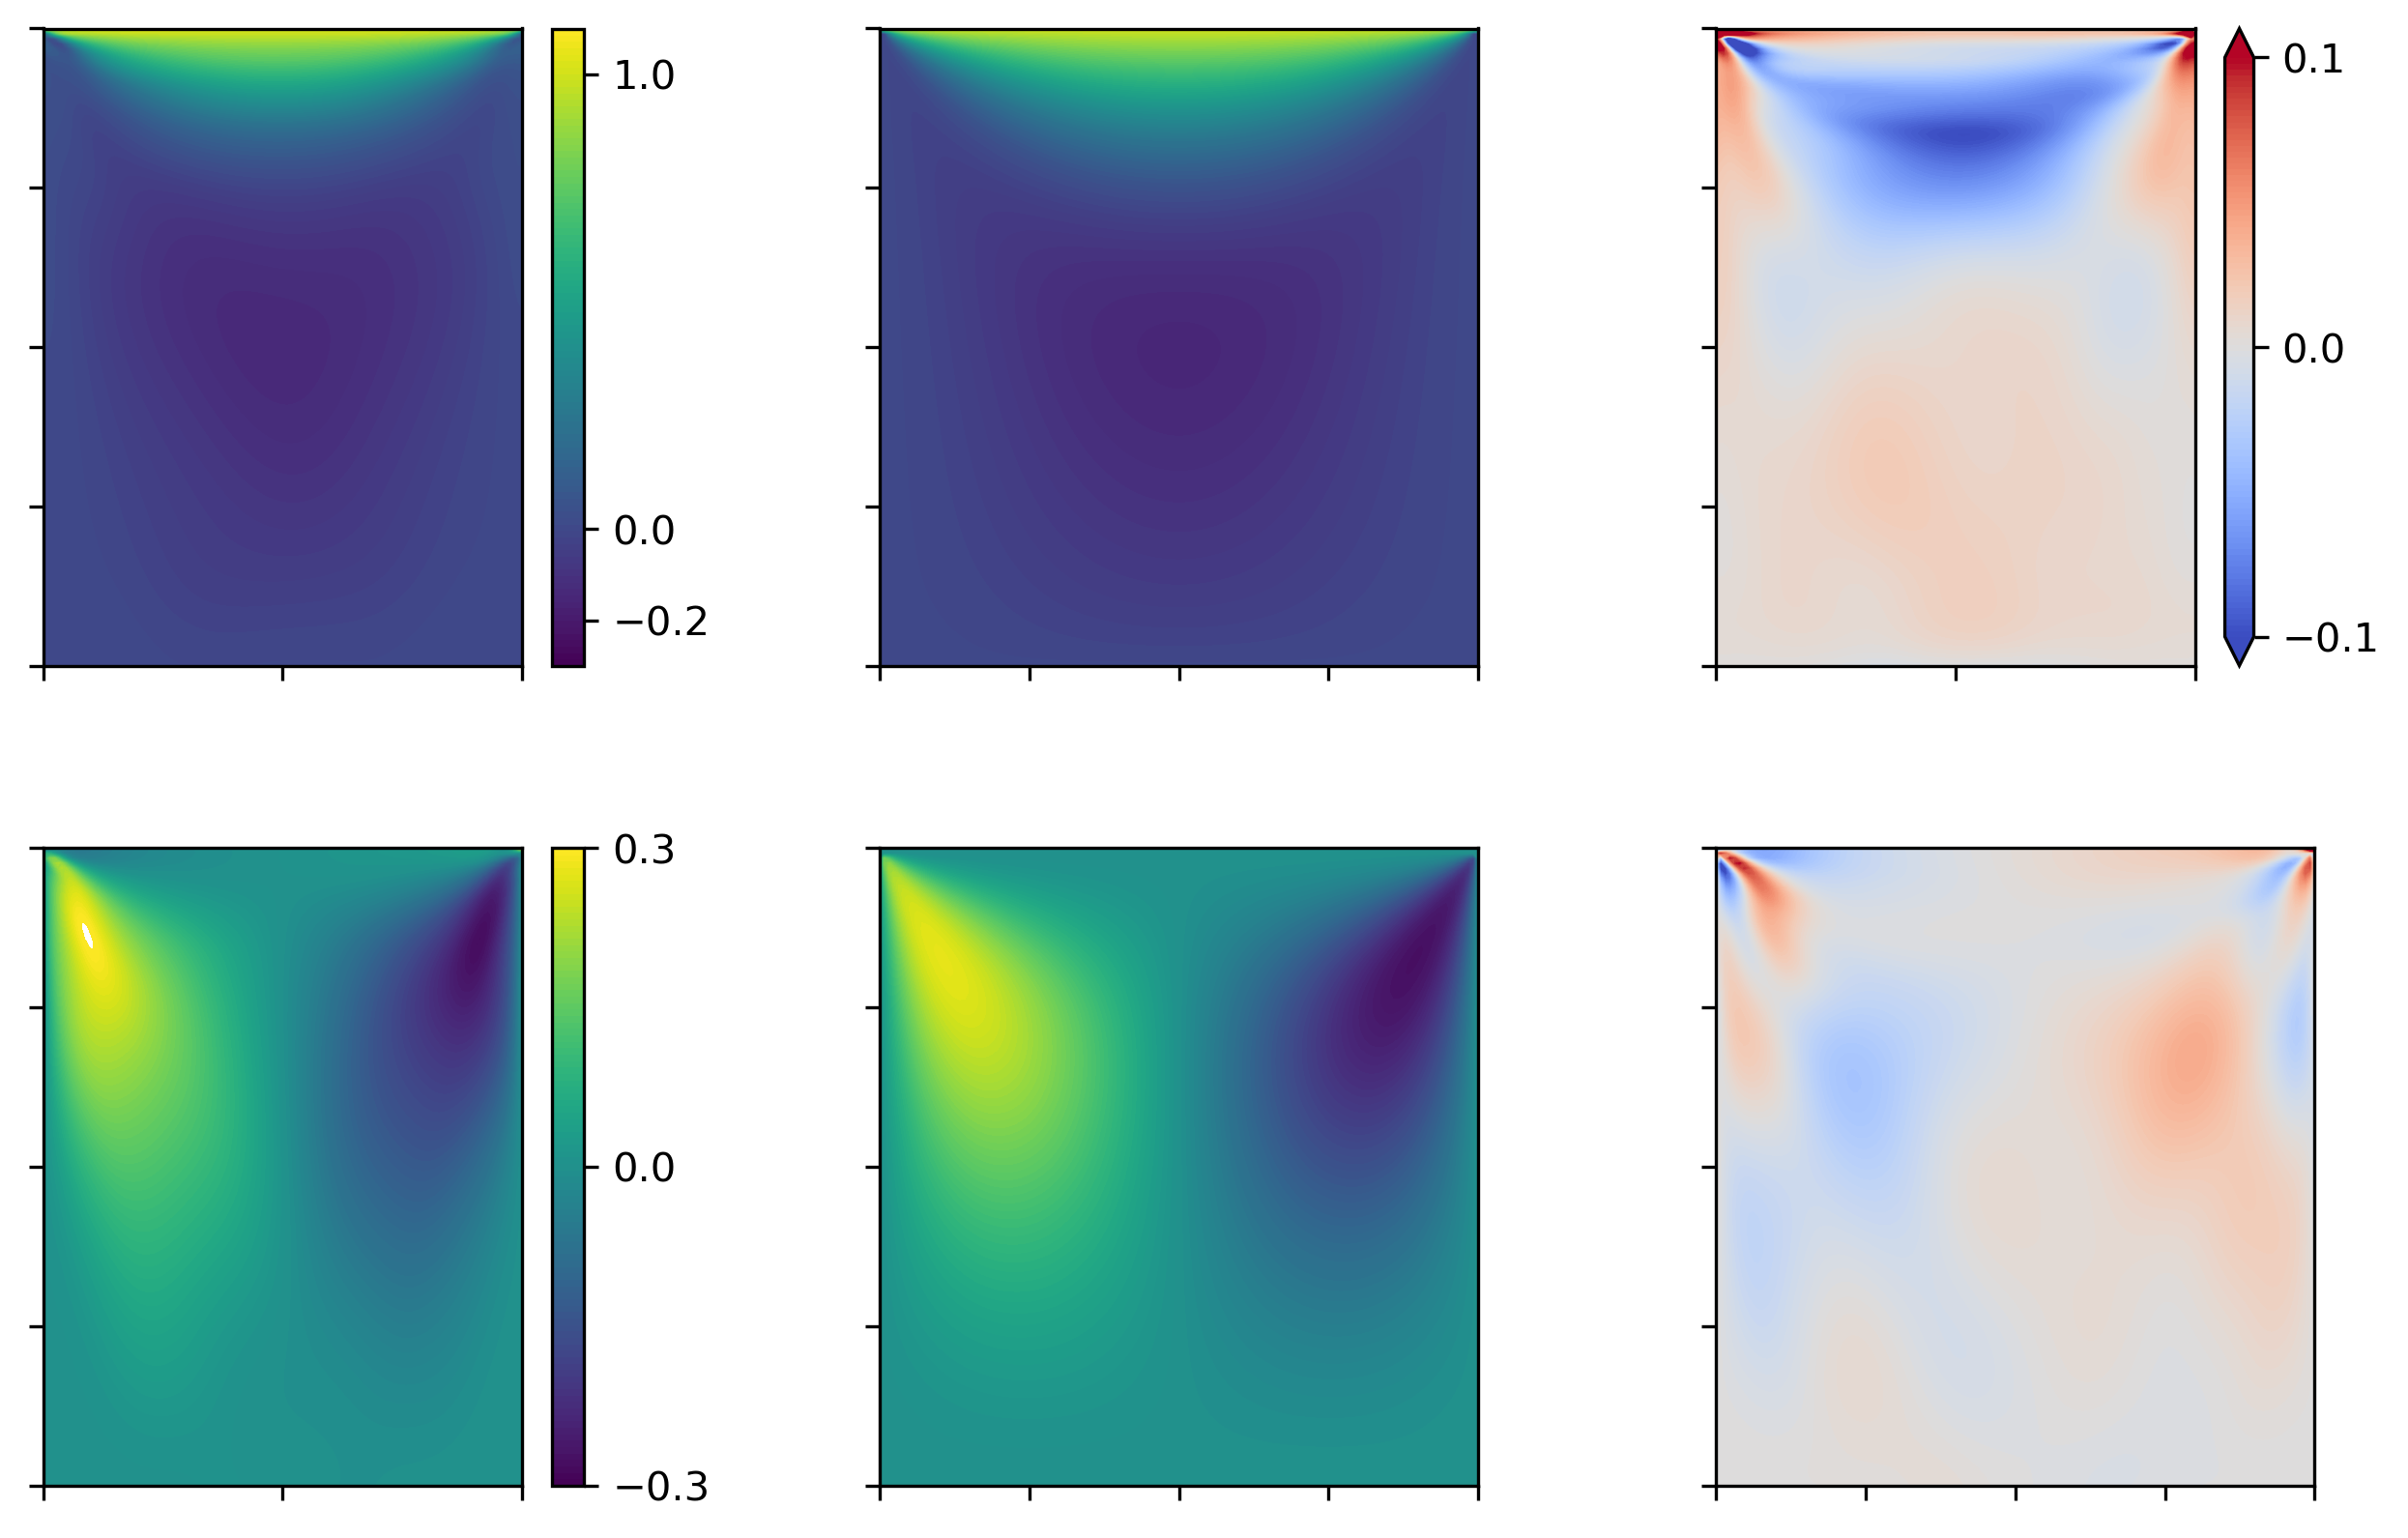

In [5]:

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

### Plotting

levels_cavity_flow_1 = np.linspace(-0.3, 1.1, 100)
ticks_cavity_flow_1  = [-0.2, 0.0, 1.0] #np.linspace(-0.2, 1.0, 2)

levels_cavity_flow_2 = np.linspace(-0.3, 0.3, 100)
ticks_cavity_flow_2  = np.linspace(-0.3, 0.3, 3)

levels_error = np.linspace(-0.1, 0.1, 100)
ticks_error = np.linspace(-0.1, 0.1, 3)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(9,6))
fig.tight_layout(pad=2.5)

contour0 = ax[0,0].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_U, levels = levels_cavity_flow_1, 
                            cmap=plt.cm.viridis)
#ax[0,0].set_xlabel(r'$x_1$')
#ax[0,0].set_ylabel(r'$x_2$')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ticks =ticks_cavity_flow_1, ax=ax[0,0])

contour1 = ax[0,1].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            u1_true, levels = levels_cavity_flow_1, 
                            cmap=plt.cm.viridis)
#ax[0,1].set_xlabel(r'$x_1$')
#ax[0,1].set_ylabel(r'$x_2$')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
#plt.colorbar(contour1, ticks =ticks_cavity_flow_1, ax=ax[0,1])

contour2 = ax[0,2].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_U - u1_true, levels = levels_error,
                            cmap=plt.cm.coolwarm, extend='both')
#ax[0,2].set_xlabel(r'$x_1$')
#ax[0,2].set_ylabel(r'$x_2$')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
plt.colorbar(contour2, ticks = ticks_error, ax=ax[0,2])

contour3 = ax[1,0].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_V, levels = levels_cavity_flow_2, 
                            cmap=plt.cm.viridis)
#ax[1,0].set_xlabel(r'$x_1$')
#ax[1,0].set_ylabel(r'$x_2$')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour3, ticks =ticks_cavity_flow_2, ax=ax[1,0])

contour4 = ax[1,1].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            u2_true, levels = levels_cavity_flow_2, 
                            cmap=plt.cm.viridis)
#ax[1,1].set_xlabel(r'$x_1$')
#ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
#plt.colorbar(contour4, ticks =ticks_cavity_flow_2, ax=ax[1,1])

contour5 = ax[1,2].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_V - u2_true, levels = levels_error,
                            cmap=plt.cm.coolwarm, extend='both')
#ax[1,2].set_xlabel(r'$x_1$')
#ax[1,2].set_ylabel(r'$x_2$')
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
#plt.colorbar(contour5, ticks = ticks_error, ax=ax[1,2])